### Decison Tree-base Approach to Predict  Customer Churn
In this task, the predicted model based on Decision-Tree classifer is built to classify whether the customer will stop using company service or not. And, the analyis of the reason behind why the customer are leaving from the service and who are those customer  are also analysed and figured out. 

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import pydotplus
from sklearn import tree
from imblearn.over_sampling import SMOTE # for handeling unbalanced data
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_auc_score, roc_curve



### Data Preparation
Here, the two dataset are used. Both are comibined and process further for analysis and building for model.

In [52]:
'''=== load dataset ===='''

df_1 =pd.read_csv('Telco-Customer-Churn.csv')
df_1 = df_1.drop('customerID', axis=1) #drop customerID column 
df_2 =pd.read_csv('Telco-Customer-Churn2.csv', sep=';')
df = pd.concat([df_1,df_2], sort=False) # concate two data frames
data = df.reset_index(drop=True) # reset index
data.tail()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
14081,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One-year,Yes,Mailed-check,84.80,1990.5,No
14082,Female,0,Yes,Yes,72,Yes,Yes,Fiber-optic,No,Yes,Yes,No,Yes,Yes,One-year,Yes,Credit-card-(automatic),103.20,7362.9,No
14083,Female,0,Yes,Yes,11,No,No-phone-service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic-check,29.60,346.45,No
14084,Male,1,Yes,No,4,Yes,Yes,Fiber-optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed-check,74.40,306.6,Yes
14085,Male,0,No,No,66,Yes,No,Fiber-optic,Yes,No,Yes,Yes,Yes,Yes,Two-year,Yes,Bank-transfer-(automatic),105.65,6844.5,No


#### Note: 
The columns- CustomerId is removed from first dataset. Since the second dataset doesn't have 'customerId' column and we are not using this column as our input feature for training the model.
    

In [53]:
'''==== Data Over-view ===='''

print ("Rows     : " ,data.shape[0])
print ("Columns  : " ,data.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())


Rows     :  14086
Columns  :  20

Features : 
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [95]:
'''===  Show descriptive statistics for numerical and categorical data (without preprocess)=== '''

#numerical only
print('Descriptive statistics for numerical\n')
print(data.describe())


#categorical only
data.describe(include='O') 

Descriptive statistics for numerical

       SeniorCitizen        tenure  MonthlyCharges  TotalCharges
count   14020.000000  14020.000000    14020.000000  14020.000000
mean        0.162767     32.520399       64.888666   2290.353388
std         0.369167     24.519567       30.063696   2266.739982
min         0.000000      1.000000       18.250000     18.800000
25%         0.000000      9.000000       35.750000    408.250000
50%         0.000000     29.000000       70.400000   1403.875000
75%         0.000000     56.000000       89.900000   3808.000000
max         1.000000     72.000000      118.750000   8684.800000


,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,14020,14020,14020,14020,14020,14020,14020,14020,14020,14020,14020,14020,14020,14020,14020,14020
unique,2,2,2,2,4,4,4,4,4,4,4,4,5,2,8,2
top,Male,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic-check,No
freq,7070,7234,9822,12660,6726,4828,6978,6158,6172,6928,5602,5546,7706,8316,2359,10306


In [96]:
# check datatype of each columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14020 entries, 0 to 14085
Data columns (total 20 columns):
gender              14020 non-null object
SeniorCitizen       14020 non-null int64
Partner             14020 non-null object
Dependents          14020 non-null object
tenure              14020 non-null int64
PhoneService        14020 non-null object
MultipleLines       14020 non-null object
InternetService     14020 non-null object
OnlineSecurity      14020 non-null object
OnlineBackup        14020 non-null object
DeviceProtection    14020 non-null object
TechSupport         14020 non-null object
StreamingTV         14020 non-null object
StreamingMovies     14020 non-null object
Contract            14020 non-null object
PaperlessBilling    14020 non-null object
PaymentMethod       14020 non-null object
MonthlyCharges      14020 non-null float64
TotalCharges        14020 non-null float64
Churn               14020 non-null object
dtypes: float64(2), int64(2), object(16)
memory usa

#### Note: 
It was found that the column 'TotalCharges' is appeared as non- float data type though it should be 
float type. So, lets convert all the values in that columns as float data type. The non numeric values changed into NaN value after following command.

In [97]:
# convert columns 'MonthlyCharges' as float data type
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14020 entries, 0 to 14085
Data columns (total 20 columns):
gender              14020 non-null object
SeniorCitizen       14020 non-null int64
Partner             14020 non-null object
Dependents          14020 non-null object
tenure              14020 non-null int64
PhoneService        14020 non-null object
MultipleLines       14020 non-null object
InternetService     14020 non-null object
OnlineSecurity      14020 non-null object
OnlineBackup        14020 non-null object
DeviceProtection    14020 non-null object
TechSupport         14020 non-null object
StreamingTV         14020 non-null object
StreamingMovies     14020 non-null object
Contract            14020 non-null object
PaperlessBilling    14020 non-null object
PaymentMethod       14020 non-null object
MonthlyCharges      14020 non-null float64
TotalCharges        14020 non-null float64
Churn               14020 non-null object
dtypes: float64(2), int64(2), object(16)
memory usa

In [105]:
'''== check Null  values in all columns ===='''
# check null values
#df.isnull().any()

# show the rows with NaN values 
data[data.isnull().any(axis=1)] 

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [99]:
#remove all Null values 
data = data.dropna()
data.shape


(14020, 20)

In [104]:
#drop duplicate except first occurance 
#data[data.duplicated()]
data = data.drop_duplicates( keep='first')
data.shape

(14020, 20)

In [10]:
# check the catergory values in each column
caterogy_column = df.select_dtypes(include='object')
for x in caterogy_column.columns:
    print(x,':', df[x].unique())
    
    

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes' 'No-phone-service']
InternetService : ['DSL' 'Fiber optic' 'No' 'Fiber-optic']
OnlineSecurity : ['No' 'Yes' 'No internet service' 'No-internet-service']
OnlineBackup : ['Yes' 'No' 'No internet service' 'No-internet-service']
DeviceProtection : ['No' 'Yes' 'No internet service' 'No-internet-service']
TechSupport : ['No' 'Yes' 'No internet service' 'No-internet-service']
StreamingTV : ['No' 'Yes' 'No internet service' 'No-internet-service']
StreamingMovies : ['No' 'Yes' 'No internet service' 'No-internet-service']
Contract : ['Month-to-month' 'One year' 'Two year' 'One-year' 'Two-year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)' 'Electronic-check' 'Mailed-check'
 'Bank-transfer-(automatic)' 'Credit-card-(automatic)']
TotalCharges : ['29.85' '1889

### Note:
In the above output, it can be seen that different words but same meaning, for example,'Fiber optic'and 'Fiber-optic', 'No phone service'and 'No-phone-service', 'One year' and 'One-year'. Thus, lets make them of same word so that it indicates that they belong to same category value.
    

In [11]:
'''==== Fix the different words  ====='''

data['InternetService'] = data['InternetService'].replace('Fiber optic', 'Fiber-optic')
data['Contract'] = data['Contract'].replace({'One year':'One-year', 'Two year': 'Two-year' })
data['PaymentMethod'] = data['PaymentMethod'].replace({'Electronic check':'Electronic-check',
                                'Mailed check':'Mailed-check', 'Bank transfer (automatic)':'Bank-transfer-(automatic)',
                                'Credit card (automatic)':'Credit-card-(automatic)' })



columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport','StreamingMovies',]
for col in columns:
    data[col] = data[col].replace('No internet service', 'No-internet-service')
    
    
    
    
# print category values in each column
for x in caterogy_column.columns:
    print(x,':', data[x].unique())
    
    


gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes' 'No-phone-service']
InternetService : ['DSL' 'Fiber-optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No-internet-service']
OnlineBackup : ['Yes' 'No' 'No-internet-service']
DeviceProtection : ['No' 'Yes' 'No-internet-service']
TechSupport : ['No' 'Yes' 'No-internet-service']
StreamingTV : ['No' 'Yes' 'No internet service' 'No-internet-service']
StreamingMovies : ['No' 'Yes' 'No-internet-service']
Contract : ['Month-to-month' 'One-year' 'Two-year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic-check' 'Mailed-check' 'Bank-transfer-(automatic)'
 'Credit-card-(automatic)']
TotalCharges : [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn : ['No' 'Yes']


In [12]:
'''=== binary code for the category values as below ==='''

binary_for = {'No': 0, 'No-internet-service': 0, 'No-phone-service': 0,'No phone service':0,
                  'No internet service':0, 'Female':0, 'Male':1, 'Yes': 1}


# binary code for category values in column
def convert_value_binary(col_names: list):
     for col in col_names:
            data[col] = data[col].replace(binary_for)


 

In [13]:
#lis of column for change its category values
columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 
        'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 
        'PaperlessBilling', 'Churn']

#call function
convert_value_binary(columns)


In [14]:
#change all modified columns values change into int data type

data[['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 
        'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 
        'PaperlessBilling', 'Churn']] = data[['gender', 'Partner', 'Dependents', 'PhoneService', 
                                            'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                                            'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 
                                            'PaperlessBilling', 'Churn']].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14020 entries, 0 to 14085
Data columns (total 20 columns):
gender              14020 non-null int64
SeniorCitizen       14020 non-null int64
Partner             14020 non-null int64
Dependents          14020 non-null int64
tenure              14020 non-null int64
PhoneService        14020 non-null int64
MultipleLines       14020 non-null int64
InternetService     14020 non-null object
OnlineSecurity      14020 non-null int64
OnlineBackup        14020 non-null int64
DeviceProtection    14020 non-null int64
TechSupport         14020 non-null int64
StreamingTV         14020 non-null int64
StreamingMovies     14020 non-null int64
Contract            14020 non-null object
PaperlessBilling    14020 non-null int64
PaymentMethod       14020 non-null object
MonthlyCharges      14020 non-null float64
TotalCharges        14020 non-null float64
Churn               14020 non-null int64
dtypes: float64(2), int64(15), object(3)
memory usage: 2.2+ MB


Class count: 
 0    10306
1     3714
Name: Churn, dtype: int64


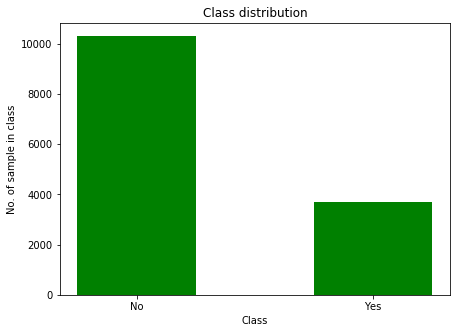

In [15]:
'''==== check class/label distribution in dataset  ===='''

class_count = data['Churn'].value_counts()
print('Class count: \n',class_count) # each class with total no. sample of data
y_pos = [class_count[0], class_count[1]] #  for y_axis 
x_pos = ['No', 'Yes'] # for axis 

# creates bar chart of class labels
plt.figure(figsize=(7,5))
plt.bar(x_pos, y_pos, width=0.50, color='g')
plt.xlabel('Class')
plt.ylabel('No. of sample in class')
plt.title('Class distribution')
plt.show()

#''' === another way to plot using frequency distribution ==='''

# creates histogram figure
#class_dist1 =list(np.array(df['Churn'])) # takes class column
#plt.figure()
#plt.hist(class_dist1)
#plt.xlabel('Class')
#plt.ylabel('No. of sample in class')
#plt.title('Class distribution')
#plt.show()


### Note:
In the above bar chart, it clearly shows that the class label are imbalanced i.e. class- Yes(27%) and class- No(73%) of total dataset. Thus, we need to upsample the class- Yes so that the model will predict the unseen data corretly to both class. Otherwise, the model will bias with the majority of class.

For handling this imblanced data, over-sampling technique(SMOTE) is used. So that the both class will have equal sample. In this case, up-sampling only to the train dataset, but test datset set should be as it is. This is done in the section below- model building.


In [16]:
#change the category values into dummy variable and drop the first column(to avoid dummy trap)

df_dummy= pd.get_dummies(data, drop_first=True)
print('Dimension of dataset after dummy variable applied:\n',df_dummy.shape)
df_dummy.head()

Dimension of dataset after dummy variable applied:
 (14020, 24)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber-optic,InternetService_No,Contract_One-year,Contract_Two-year,PaymentMethod_Credit-card-(automatic),PaymentMethod_Electronic-check,PaymentMethod_Mailed-check
0,0,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


In [17]:
# summary of the final dataset
df_dummy.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,14020.0,0.504280,0.500000,0.00,0.00,1.000,1.0,1.00
SeniorCitizen,14020.0,0.162767,0.369167,0.00,0.00,0.000,0.0,1.00
Partner,14020.0,0.484023,0.499762,0.00,0.00,0.000,1.0,1.00
Dependents,14020.0,0.299429,0.458024,0.00,0.00,0.000,1.0,1.00
tenure,14020.0,32.520399,24.519567,1.00,9.00,29.000,56.0,72.00
PhoneService,14020.0,0.902996,0.295974,0.00,1.00,1.000,1.0,1.00
MultipleLines,14020.0,0.423252,0.494092,0.00,0.00,0.000,1.0,1.00
OnlineSecurity,14020.0,0.287447,0.452588,0.00,0.00,0.000,1.0,1.00
OnlineBackup,14020.0,0.345934,0.475689,0.00,0.00,0.000,1.0,1.00
DeviceProtection,14020.0,0.344936,0.475364,0.00,0.00,0.000,1.0,1.00


### Model Building
Decision-Tree classifer is built using  two attributes selction methods (gini and entropy).  Firstly, the model is trained with all the features and  seconldy trained with selected feature(feature selection) and compare the result. The  gridSearchCV is used to find the optimal parameter such as max_depth and attribution selection criteria.


In [18]:
'''===  Build model  ==='''

#split data into train (70%) and test (30%)
def data_split(data, test_size):
    '''
    data = data to split
    test_size = size of test-data
    '''
    train, test = train_test_split(data, stratify=data['Churn'], test_size = test_size, random_state=3)
    X_train = train.drop(['Churn'], axis=1) # drop 'Churn' column
    y_train = train['Churn'] # Churn column for train 
    X_test = test.drop(['Churn'], axis=1) # drop 'Churn' column
    y_test = test['Churn'] # Churn column for test

    return X_train, y_train, X_test, y_test


In [19]:
#call data split function
X_train, y_train, X_test, y_test = data_split(df_dummy, 0.3)


In [20]:
# check ratio of train and test based on class label
print(y_test.value_counts()[0]/(y_test.value_counts()[1]+y_test.value_counts()[0])) # class 'No churn'
print(y_test.value_counts()[1]/(y_test.value_counts()[1]+y_test.value_counts()[0])) #clas 'Churn'


0.7351402757964812
0.2648597242035188


In [21]:
'''=== Since data is of imblanced classes, up-sampling should be done to the minority class. So that it becomes 
  balanced. This is done only to train data but not to test data ==='''

#over-sampling the data
def up_sampling(X_train, y_train):
    '''
    X_train = Input features of training dataset
    y_train = Ouput/class of training dataset
    '''
    sm = SMOTE(random_state=42, ratio=1.0) # SMOTE is apply for up-sampling
    X_train_new, y_train_new = sm.fit_sample(X_train, y_train) # up-sampling only the train data
    return X_train_new, y_train_new

In [22]:
# call up_sampling function
X_train_new, y_train_new = up_sampling(X_train, y_train)
print('Before up-sampling:\n', y_train.value_counts())
print()
print('\n After up-sampling:', np.bincount(y_train_new))



Before up-sampling:
 0    7214
1    2600
Name: Churn, dtype: int64


 After up-sampling: [7214 7214]


In [23]:
        '''=== Decision-Tree Classifier ==='''

#build model
def decision_tree_classifier(criterion, max_depth, X_train, y_train):
    decision_tree = DecisionTreeClassifier(criterion= criterion, max_depth=max_depth, random_state=42)
    decision_tree.fit(X_train, y_train) # train model
    return decision_tree
    

In [24]:
#call function (with manual, criterion:'entropy', max_depth:4)
deci_without_tune = decision_tree_classifier('entropy',4,X_train_new, y_train_new )
deci_without_tune

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

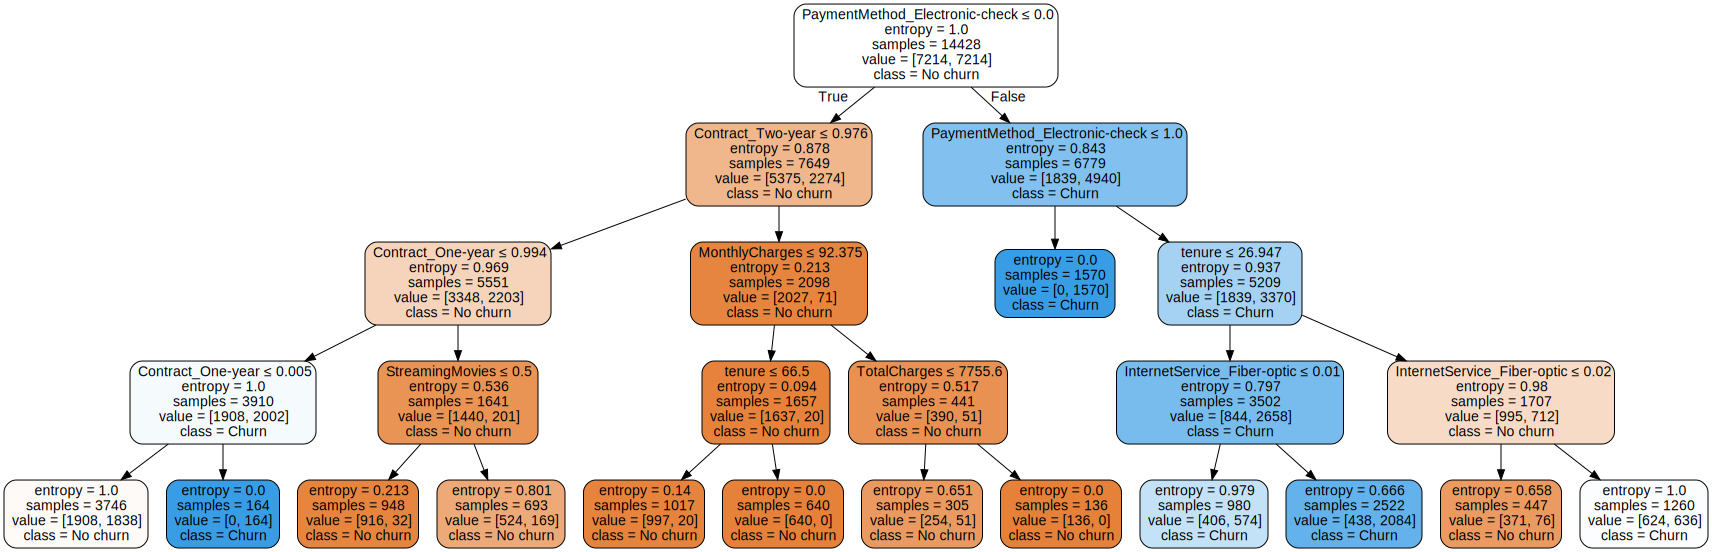

In [25]:

# show in tree-structure 
churnTree = tree.export_graphviz(deci_without_tune, out_file=None, 
                         feature_names = list(X_train.columns.values),  
                         class_names = [ 'No churn', 'Churn'],
                         filled=True, 
                         rounded=True,
                         special_characters=True)  
graph = graphviz.Source(churnTree) 
#graph.render('decision_tree.gv', view=True)
pydot_graph = pydotplus.graph_from_dot_data(churnTree)
pydot_graph.write_png('original_tree.png') # shave figure
#pydot_graph.set_size('"5,5!"')
#pydot_graph.write_png('resized_tree.png')
graph

In [26]:
'''==== Model Evalution ===='''

predict = deci_without_tune.predict(X_test)  # prediciton on test data
accu_score = accuracy_score(predict, y_test)# clasification accuracy
con_matrix = confusion_matrix(predict, y_test) # confusion matrix
cla_report = classification_report(predict, y_test) # classification report
print( 'Classification acurracy:', accu_score)
print('\nConfusion Matrix:\n', con_matrix)
print('\nclassification_report:\n', cla_report )


Classification acurracy: 0.7401331431288636

Confusion Matrix:
 [[2492  493]
 [ 600  621]]

classification_report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      2985
           1       0.56      0.51      0.53      1221

   micro avg       0.74      0.74      0.74      4206
   macro avg       0.68      0.67      0.68      4206
weighted avg       0.73      0.74      0.74      4206



### Parameter Tuning
The best paramter for the classifier is tunned using the 10-Folds cross-validation. The GridSearchCV() is used.

In [27]:
#parameter tunining
best_parameter= DecisionTreeClassifier( random_state=42) # call decision tree
parameters = {'criterion':['entropy','gini'],
              'max_depth':range(1,100)
              #'max_features': [ 5, 10, 12],
              #'splitter': ['best','random'],
             }
clf = GridSearchCV(best_parameter, parameters, cv=10) # gridsearch with 10-folds cv
clf.fit(X_train_new,y_train_new) # tuninig in train dataset

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': range(1, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
# check best parameter
clf.best_params_

{'criterion': 'entropy', 'max_depth': 29}

In [29]:
#check best_score
clf.best_score_

0.9271555309121153

In [30]:
''' ==== Used the best parameter for model training ==== '''

#call function (with criterion:'entropy', max_depth:4)
deci_with_tune = decision_tree_classifier('entropy', 29, X_train_new, y_train_new )
deci_with_tune

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=29,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [31]:
'''==== Model Evalution Using best parameters ===='''

predict_tuned = deci_with_tune.predict(X_test)  # prediciton on test data
accu_score = accuracy_score(predict_tuned , y_test)# clasification accuracy
con_matrix = confusion_matrix(predict_tuned , y_test) # confusion matrix
cla_report = classification_report(predict_tuned , y_test) # classification report
print( 'Classification acurracy:', accu_score)
print('\nConfusion Matrix:\n', con_matrix)
print('\nclassification_report:\n', cla_report )


Classification acurracy: 0.9236804564907275

Confusion Matrix:
 [[2950  179]
 [ 142  935]]

classification_report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      3129
           1       0.84      0.87      0.85      1077

   micro avg       0.92      0.92      0.92      4206
   macro avg       0.90      0.91      0.90      4206
weighted avg       0.92      0.92      0.92      4206



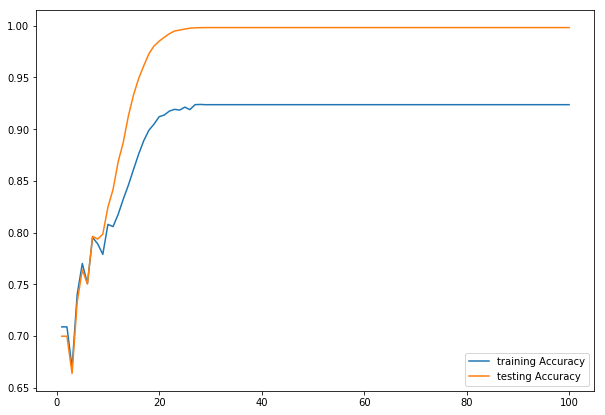

In [32]:

'''==== plot train and test score with respect to 1-100 max_depth ===='''

acc_train = []
acc_test = []

for n in range(1,101):
    deci_with_tune = decision_tree_classifier('entropy', n, X_train_new, y_train_new )
    predict_tuned = deci_with_tune.predict(X_test)  # prediciton on test data
    accu_score = accuracy_score(predict_tuned , y_test)# clasification accuracy
    acc_train.append(accu_score)
    
    train_predict_tuned = deci_with_tune.predict(X_train)  # prediciton on test data
    train_accu_score = accuracy_score(train_predict_tuned , y_train)# clasification accuracy
    acc_test.append(train_accu_score)

#print(acc_train)
#print(acc_test)

#creates figure
plt.figure(figsize=(10,7))
x = np.arange(1, 101) # for x-axis
plt.plot(x, acc_train, label='training Accuracy' )
plt.plot(x, acc_test, label='testing Accuracy' )
plt.legend()
plt.show()

### Lets try with selected features

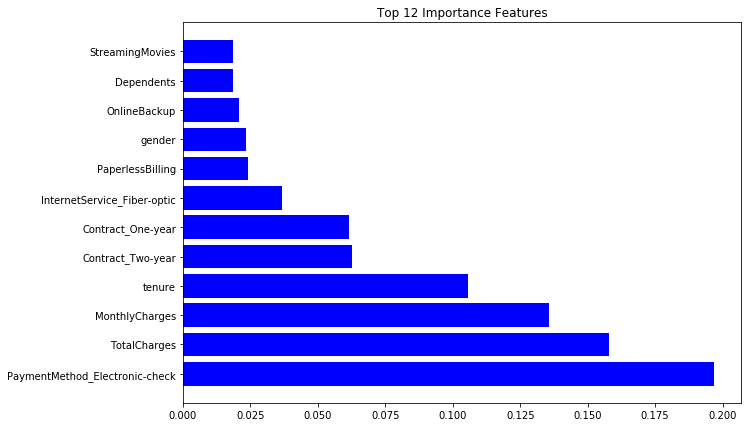

In [33]:
'''==== Show Top 12 features contribution to target labels ==='''

coeffs = deci_with_tune.feature_importances_
list_of_coeffs = list(sorted(zip(coeffs, X_train.columns), reverse=True))
x_val = [x[0] for x in list_of_coeffs[:12]]
y_val = [x[1] for x in list_of_coeffs[:12]]

#create figure
plt.figure(figsize=(10,7))
plt.barh( y_val, x_val, align='center', color='b')
plt.title('Top 12 Importance Features')
plt.show()

#feat_importances = pd.Series(coeffs, index=X_train.columns)
#feat_importances.nlargest(10).plot(kind='barh')



In [34]:
'''== build model with top 12 features ==='''
data_selected_features= pd.concat([df_dummy[y_val], df_dummy['Churn']], axis=1) #data with top 12 features
X_train_se, y_train_se, X_test_se, y_test_se = data_split(data_selected_features, 0.3) #call data split function
X_train_newfea, y_train_newfea = up_sampling(X_train_se, y_train_se) # call up-sampling function


#parameter tunining with selected featues but same parameter
best_parameter= DecisionTreeClassifier( random_state=42) # call decision tree
parameters = {'criterion':['entropy','gini'],
              'max_depth':range(1,100)
              #'max_features': [ 5, 10, 12],
              #'splitter': ['best','random'],
             }
clf = GridSearchCV(best_parameter, parameters, cv=10) # gridsearch with 10-folds cv
clf.fit(X_train_newfea,y_train_newfea) # tuninig in train dataset




GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': range(1, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
#best parameter
best_pa = clf.best_params_
best_pa

{'criterion': 'entropy', 'max_depth': 32}

In [36]:

'''==== Model Evalution Using best parameters ===='''

selected_features_tuned = decision_tree_classifier(list(best_pa.values())[0], list(best_pa.values())[1], X_train_se, y_train_se ) # with best paramter
predict_tuned_f = selected_features_tuned.predict(X_test_se)  # prediciton on test data
accu_score = accuracy_score(predict_tuned_f , y_test_se)# clasification accuracy
con_matrix = confusion_matrix(predict_tuned_f , y_test_se) # confusion matrix
cla_report = classification_report(predict_tuned_f , y_test_se) # classification report
print( 'Classification acurracy:', accu_score)
print('\nConfusion Matrix:\n', con_matrix)
print('\nclassification_report:\n', cla_report )


Classification acurracy: 0.9213029006181646

Confusion Matrix:
 [[2924  163]
 [ 168  951]]

classification_report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      3087
           1       0.85      0.85      0.85      1119

   micro avg       0.92      0.92      0.92      4206
   macro avg       0.90      0.90      0.90      4206
weighted avg       0.92      0.92      0.92      4206



#### ROC-Curve plot

Auc_score: 0.9012319102287482
Auc_score: 0.9055251462626667


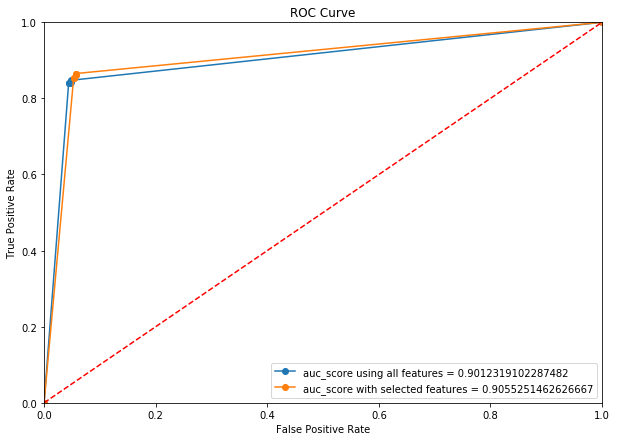

In [37]:
'''=== ROC curve  plot ===='''

# using all features
y_test_prob_tune = deci_with_tune.predict_proba(X_test)#class probabilities for Auc_score
prob_pstive = [p[1] for p in y_test_prob_tune] # probabilty for positive class
auc_score = roc_auc_score(y_test, prob_pstive)
print('Auc_score:', auc_score)

#using only selected features
y_test_prob_tuned = selected_features_tuned.predict_proba(X_test_se)#class probabilities for Auc_score
prob_pstived = [p[1] for p in y_test_prob_tuned] # probabilty for positive class
auc_score_selected_feature = roc_auc_score(y_test_se, prob_pstived)
print('Auc_score:', auc_score_selected_feature)




#create figure- area under curve
fpr,tpr,thresholds = roc_curve(y_test, prob_pstive) # find true positve, false positive rate and thresholds
fpr1,tpr1,thresholds = roc_curve(y_test_se, prob_pstived)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, marker='o',label="auc_score using all features = " + str(auc_score))
plt.plot(fpr1, tpr1, marker='o',label="auc_score with selected features = " + str(auc_score_selected_feature))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

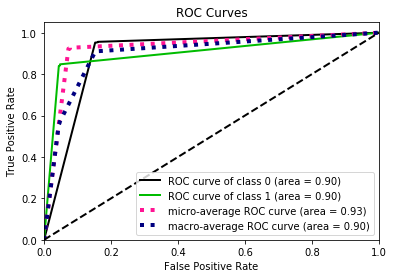

In [38]:
'''=== Another way to draw ROC curve, so handy and efficent === '''
import scikitplot as skplt
y_true = y_test# ground truth labels
y_probas = prob_pstive# predicted probabilities 

skplt.metrics.plot_roc(y_true, y_test_prob_tune) # takes  true and predicted lalels
plt.show()

### Result:
With the paramter tuning, the model performace is increased from   0.72796 to 0.91350% classification accuracy. Even the recall and precious for both class get increased, which indicates that the model can classify the customer whether he/she will churn or not, if this dataset representts the real world problem. From the confusion matrix also one can see, the model classifies better.

The best parameters for this model(decision-tree) in this dataset is: {'criterion': 'entropy', 'max_depth': 29}. For finding this, the modle is trained  and tested with different paramerters such as 'entropy' and 'gini' with the use of  max_depth from  1 to 100 range. To do this gridSearchCV is performed.



###  Analysis  of Customer Churn 
In this section, the reasons behind customer churn are discussed and those customer likely to leave from using services are figured out. 

In [39]:
# show columns of dataframe
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

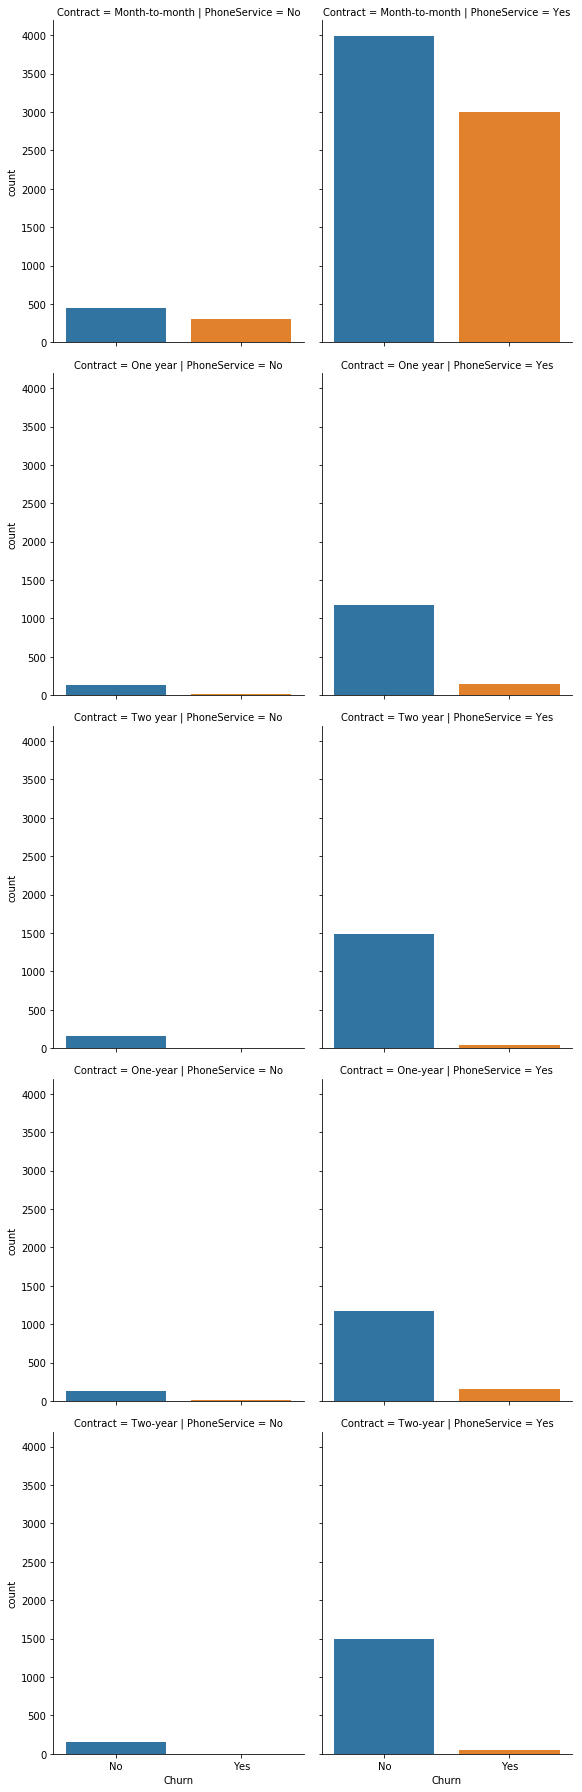

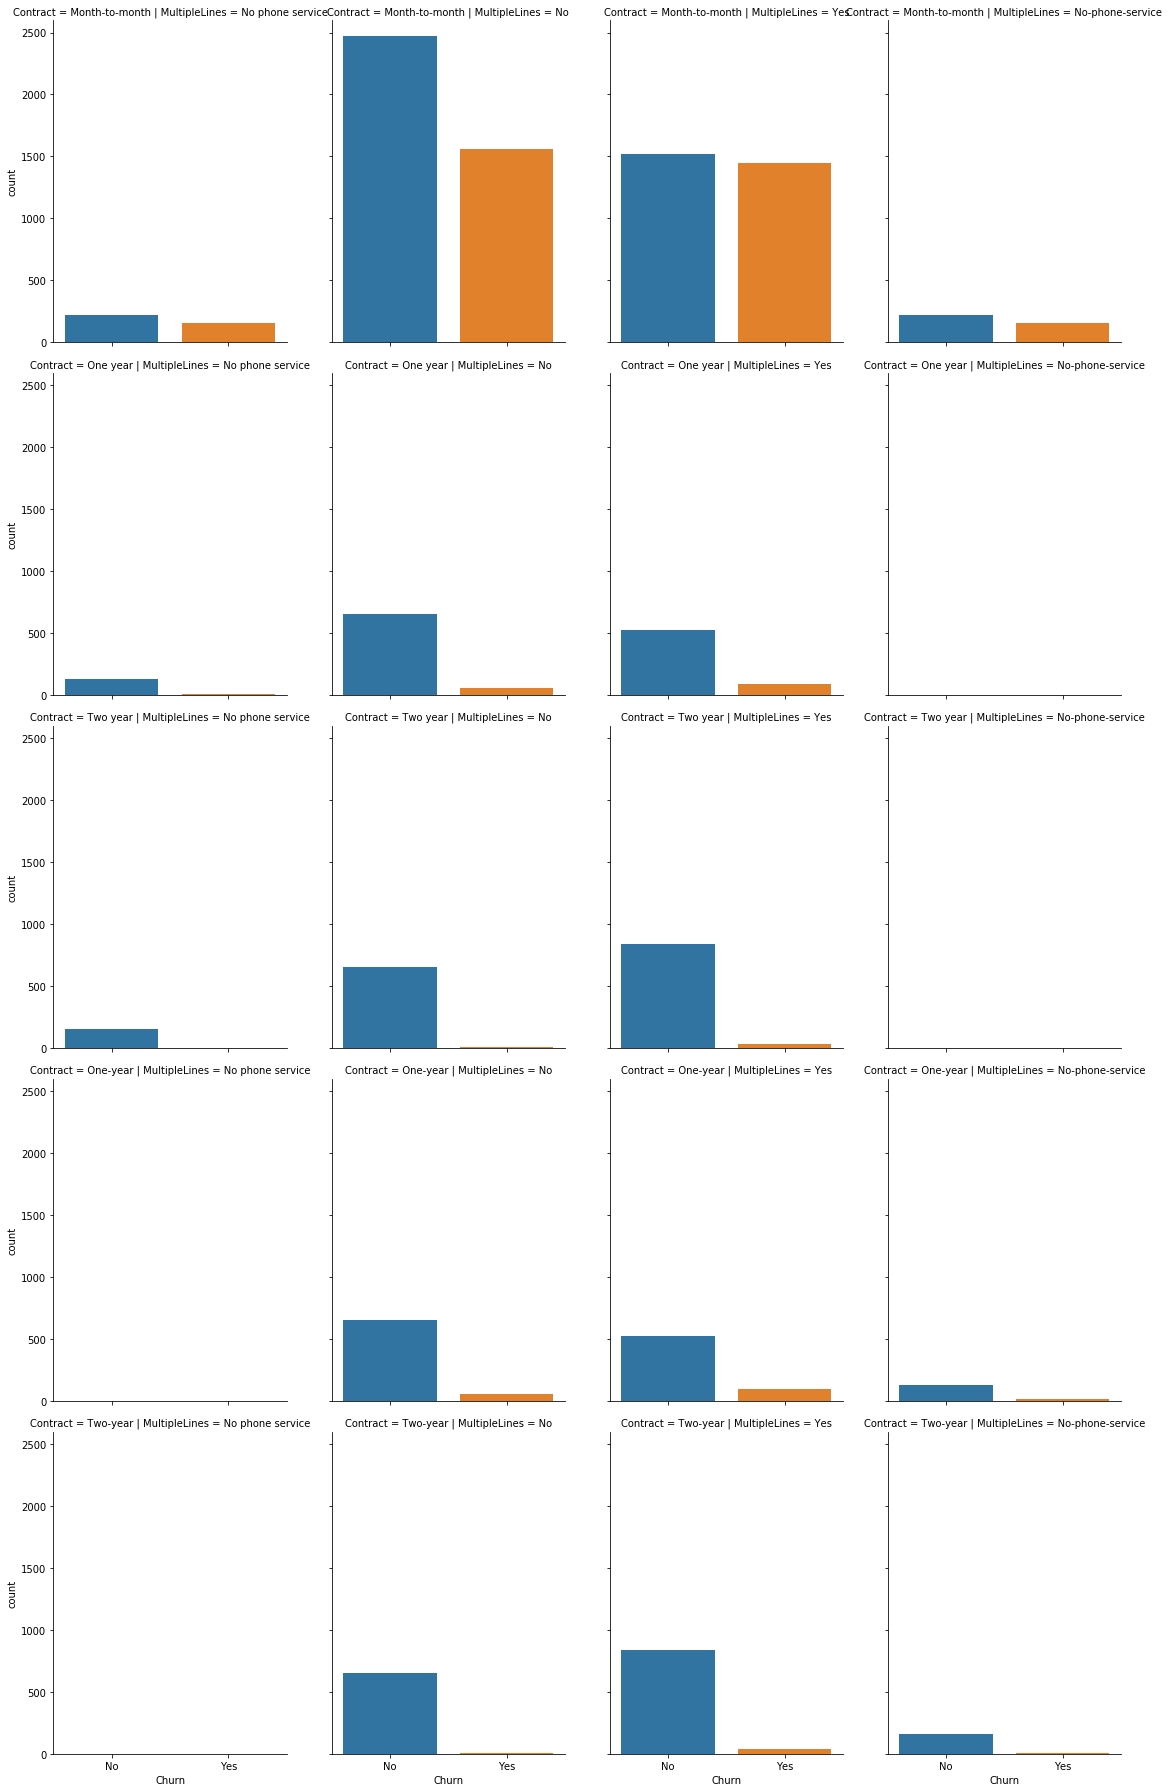

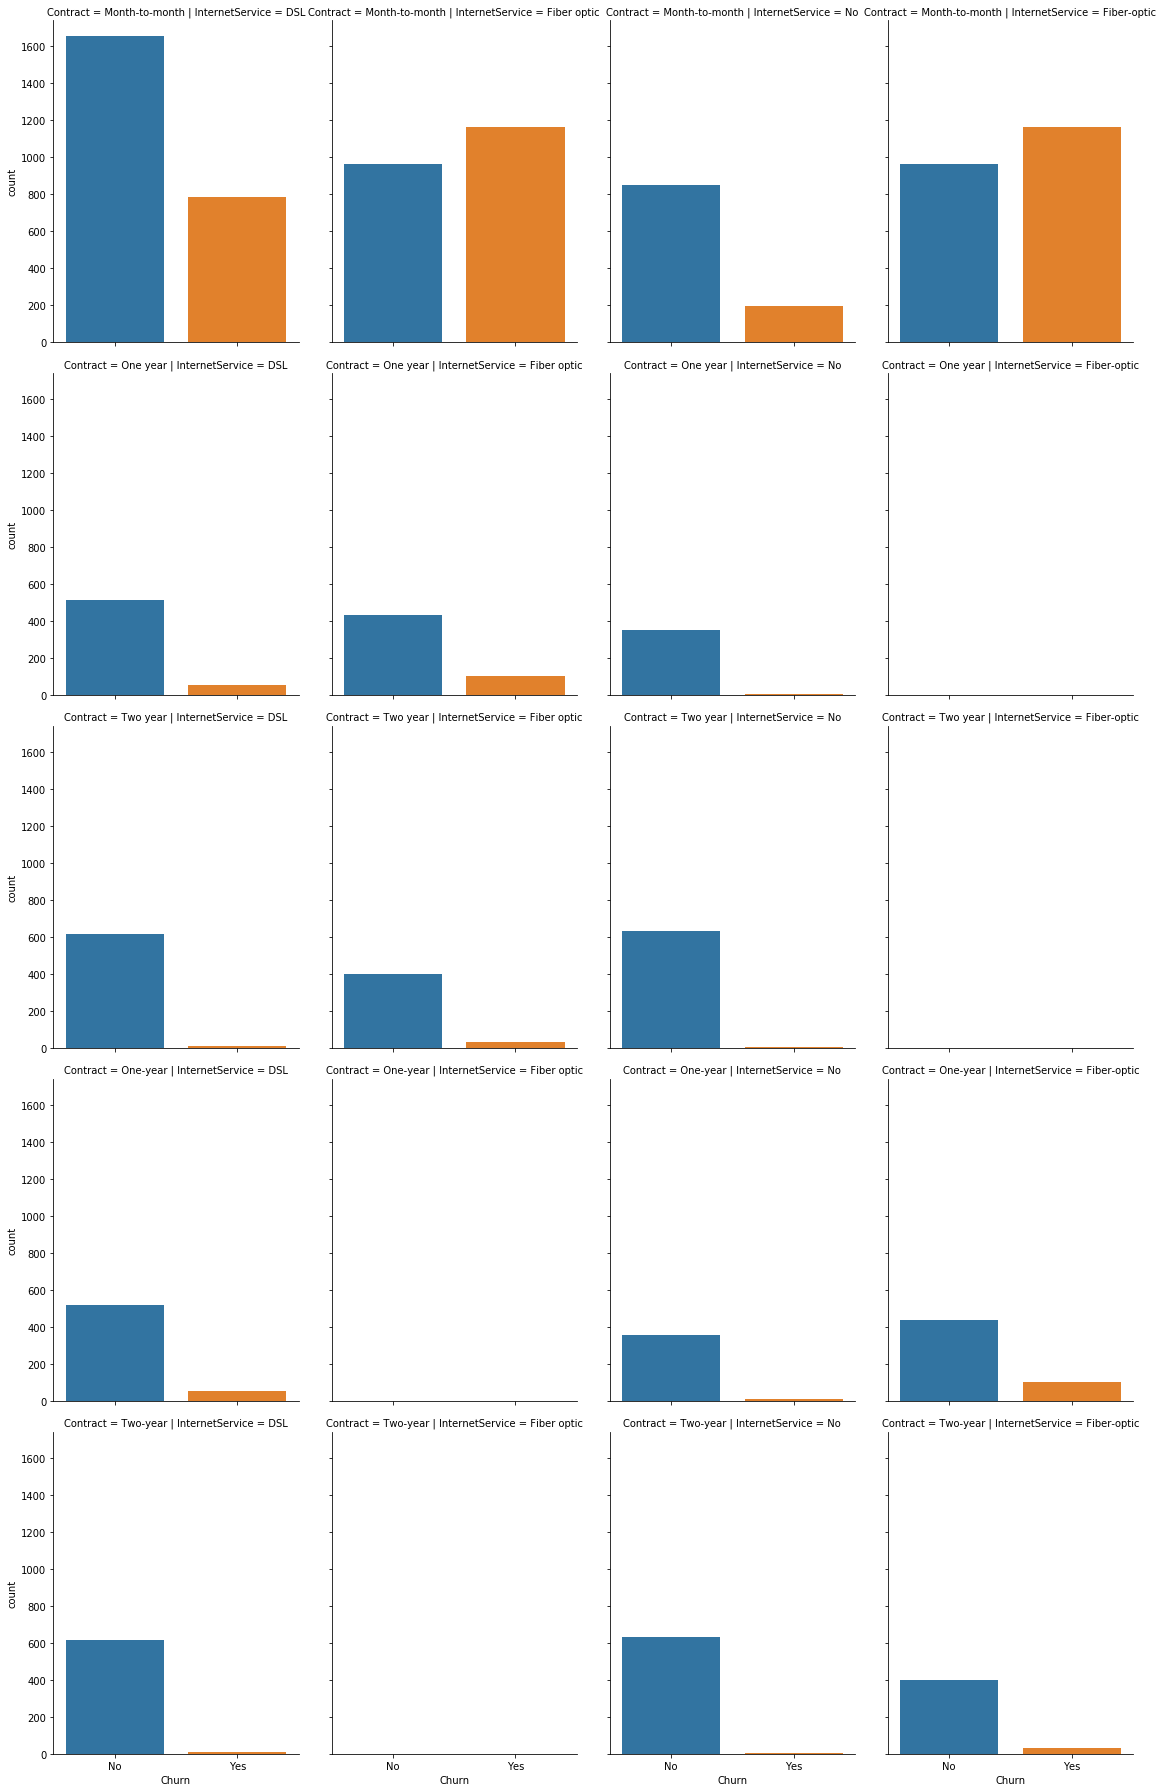

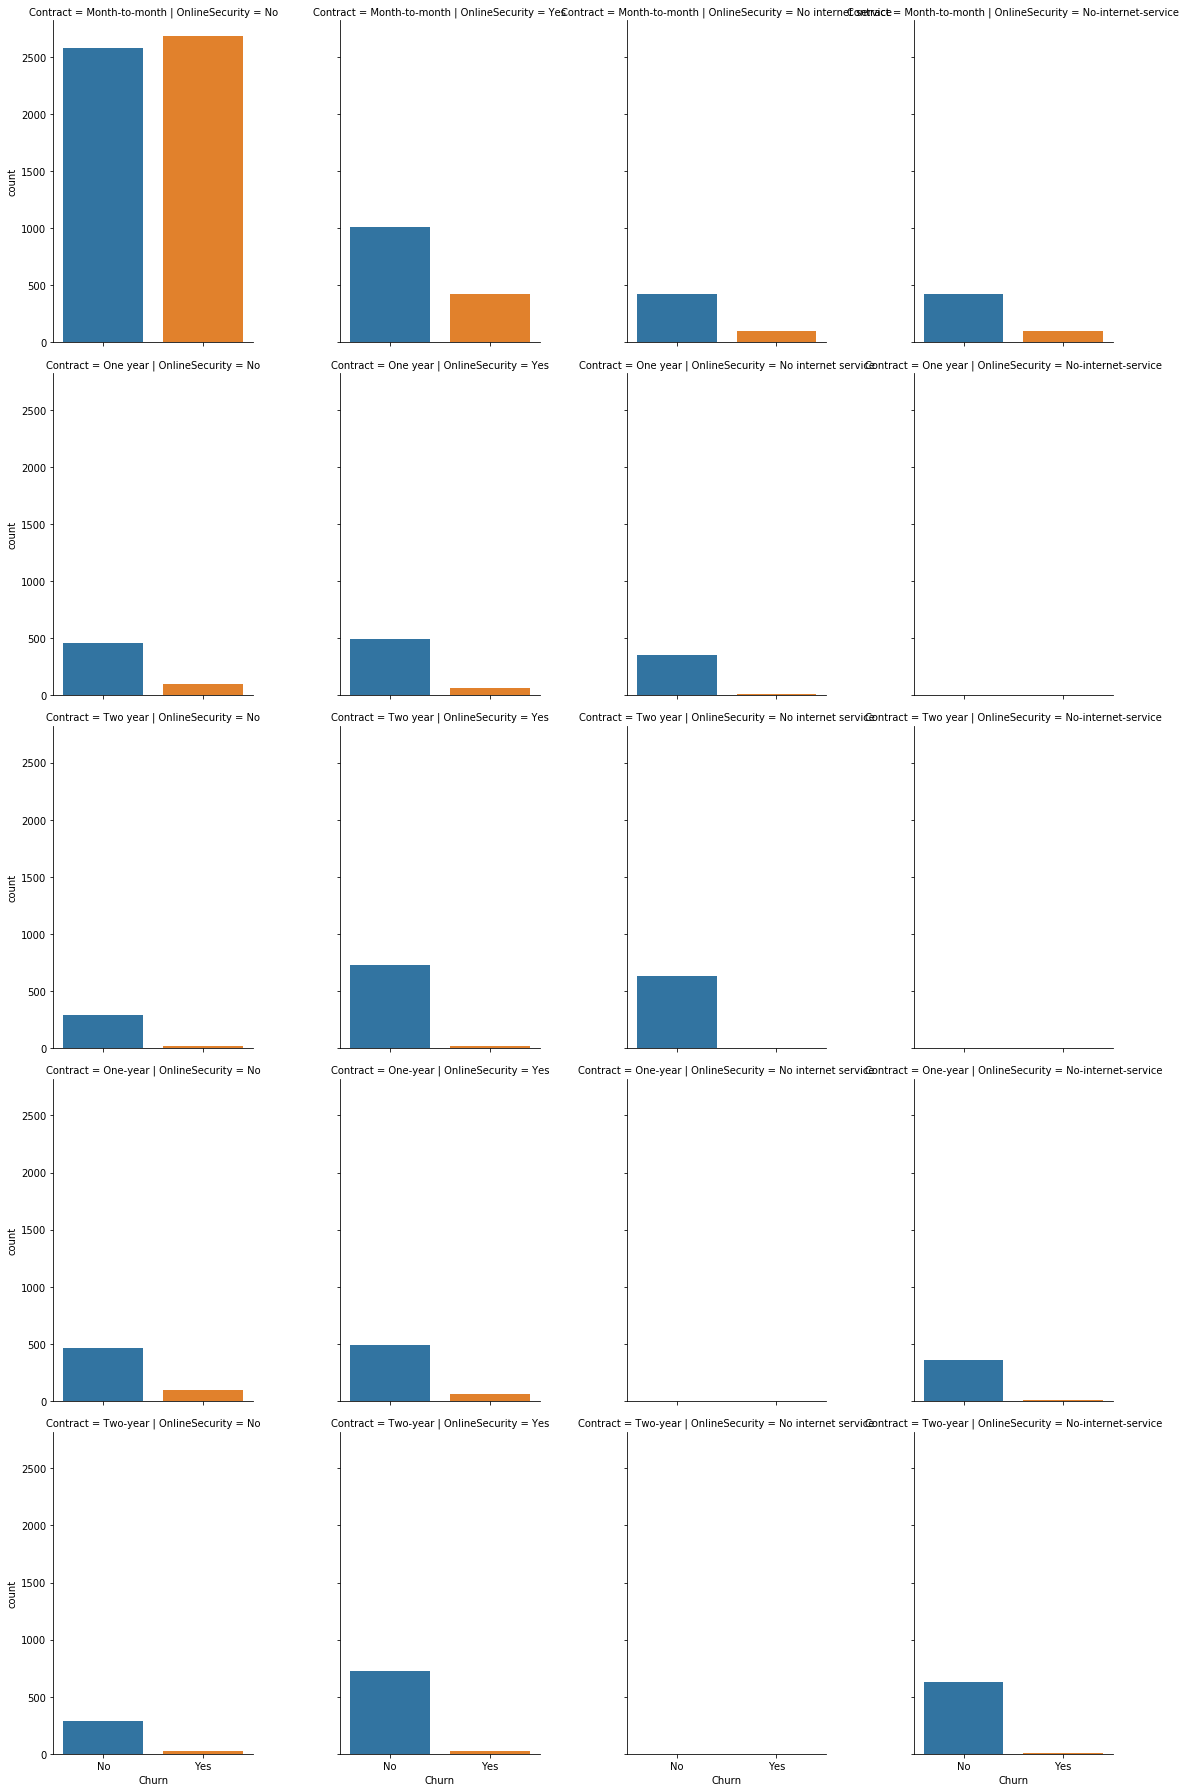

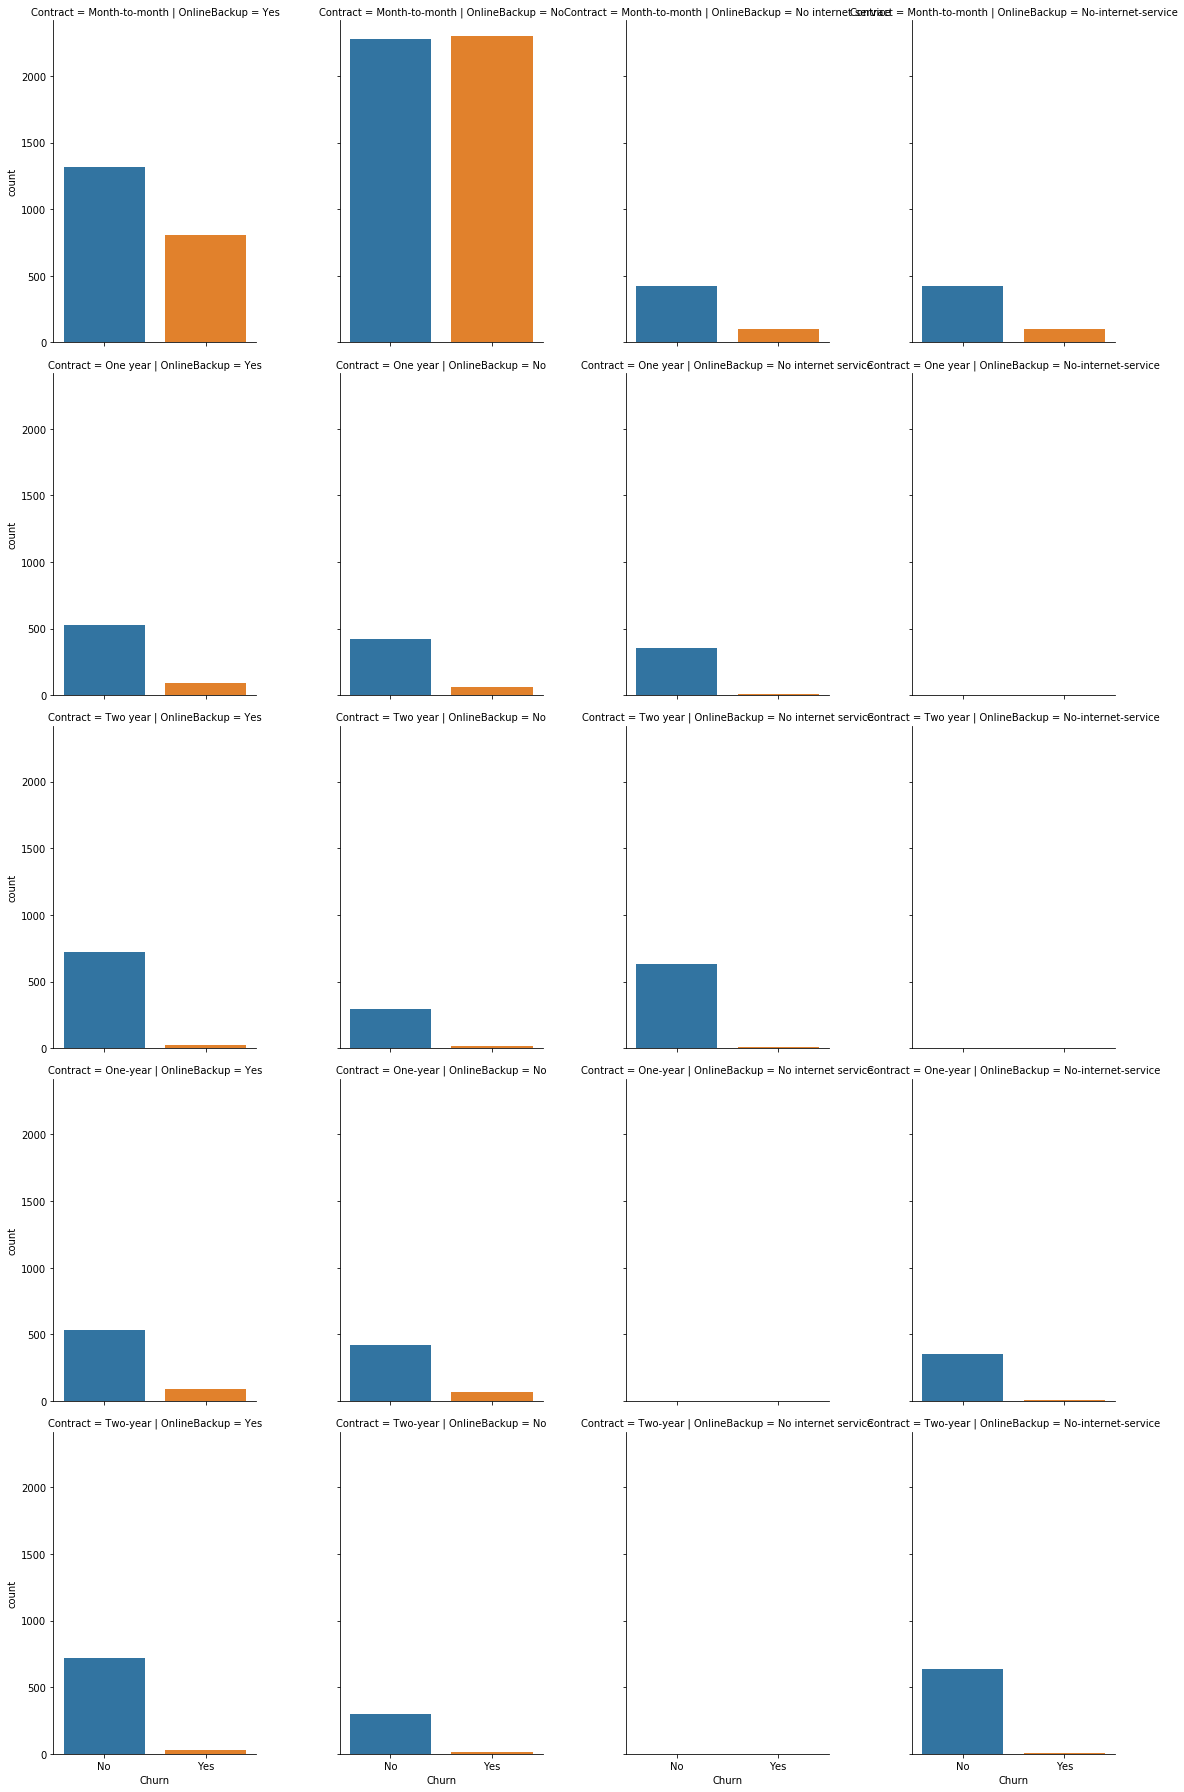

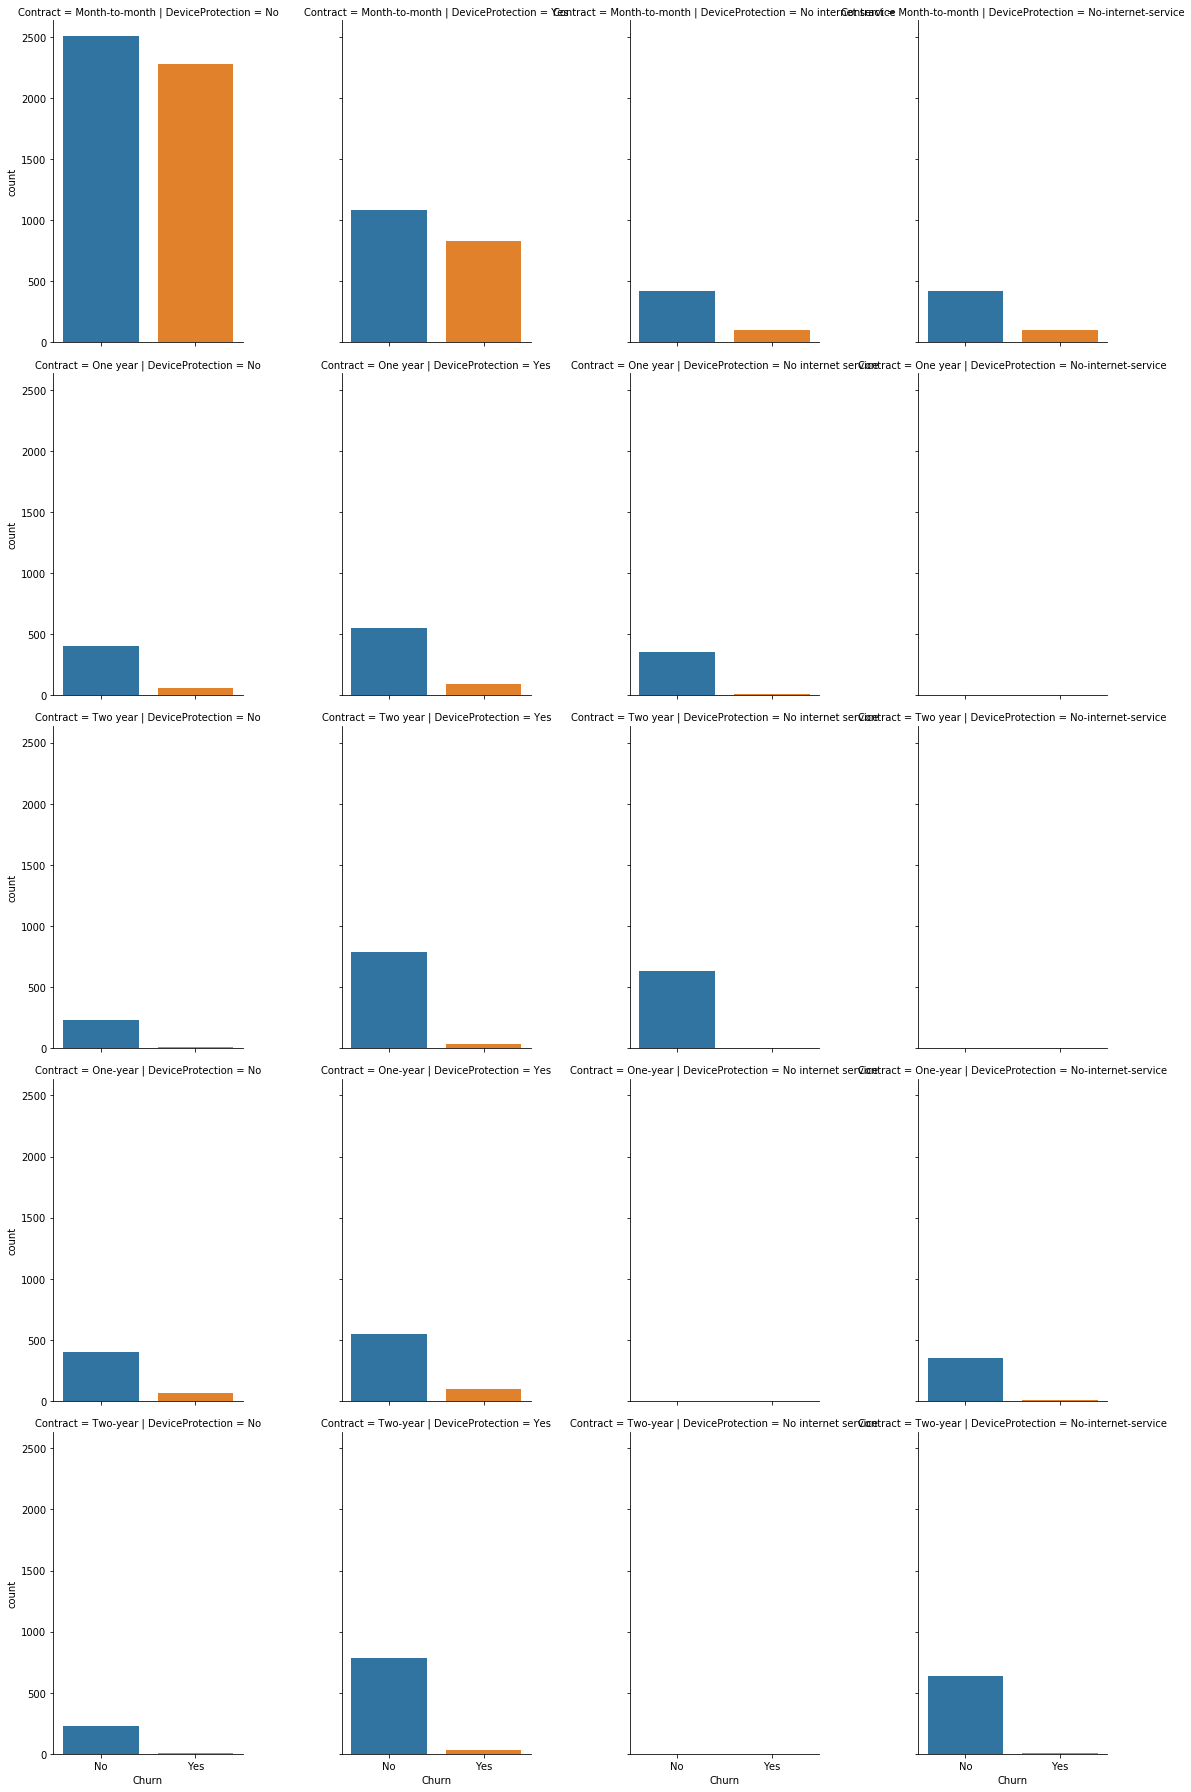

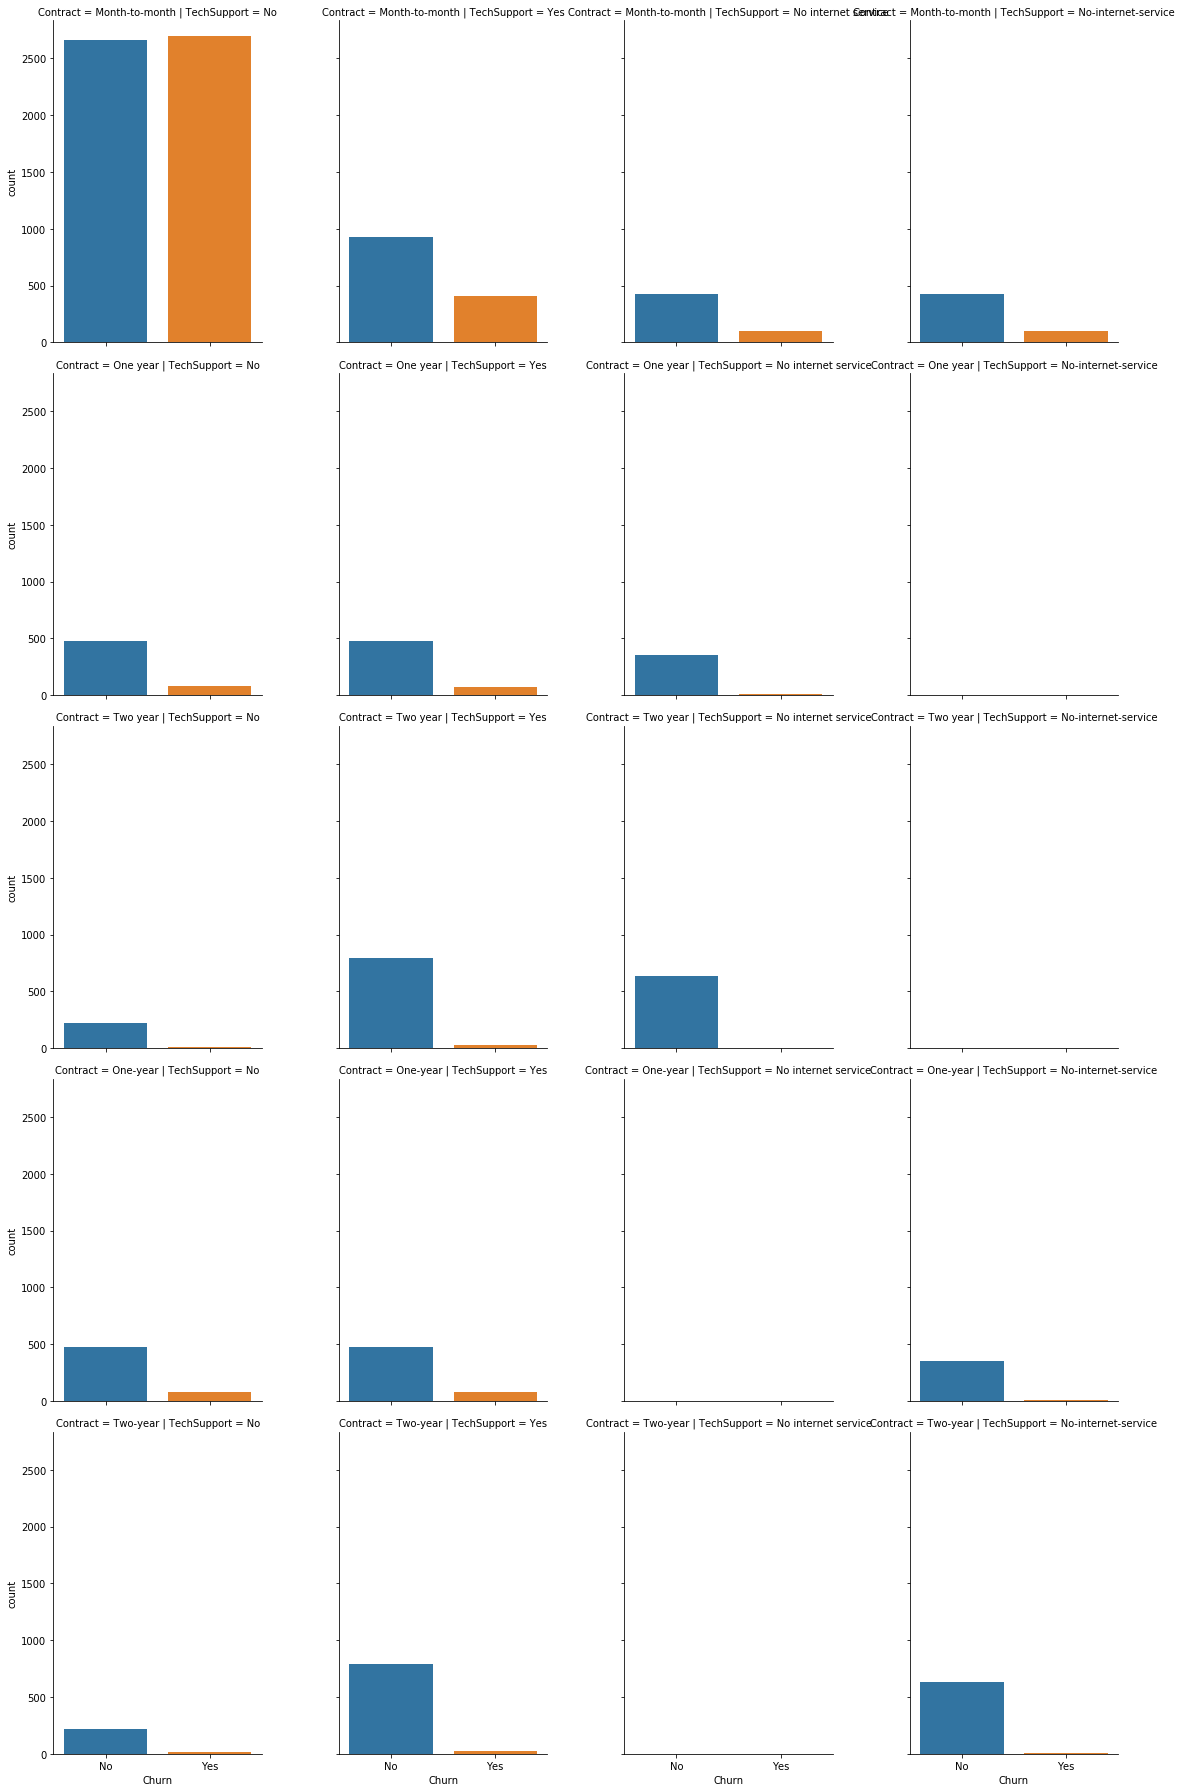

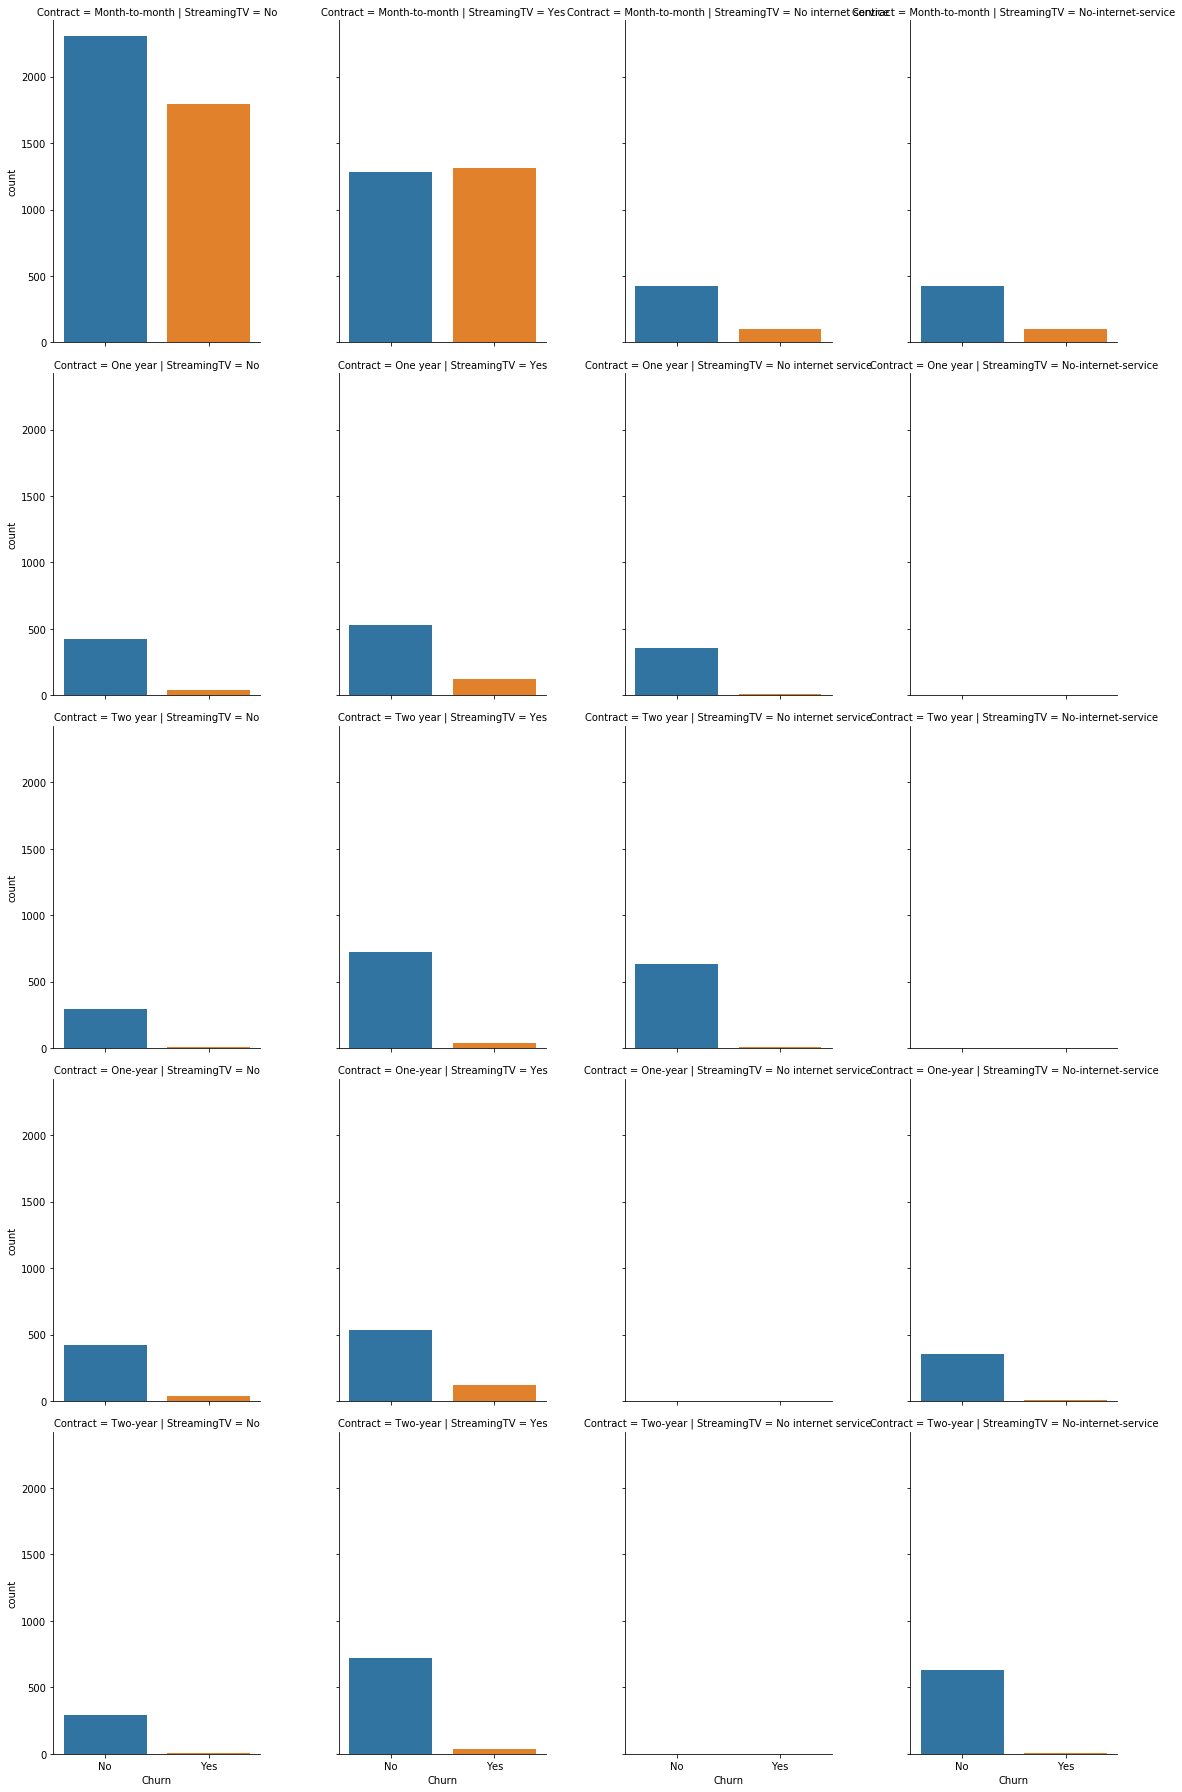

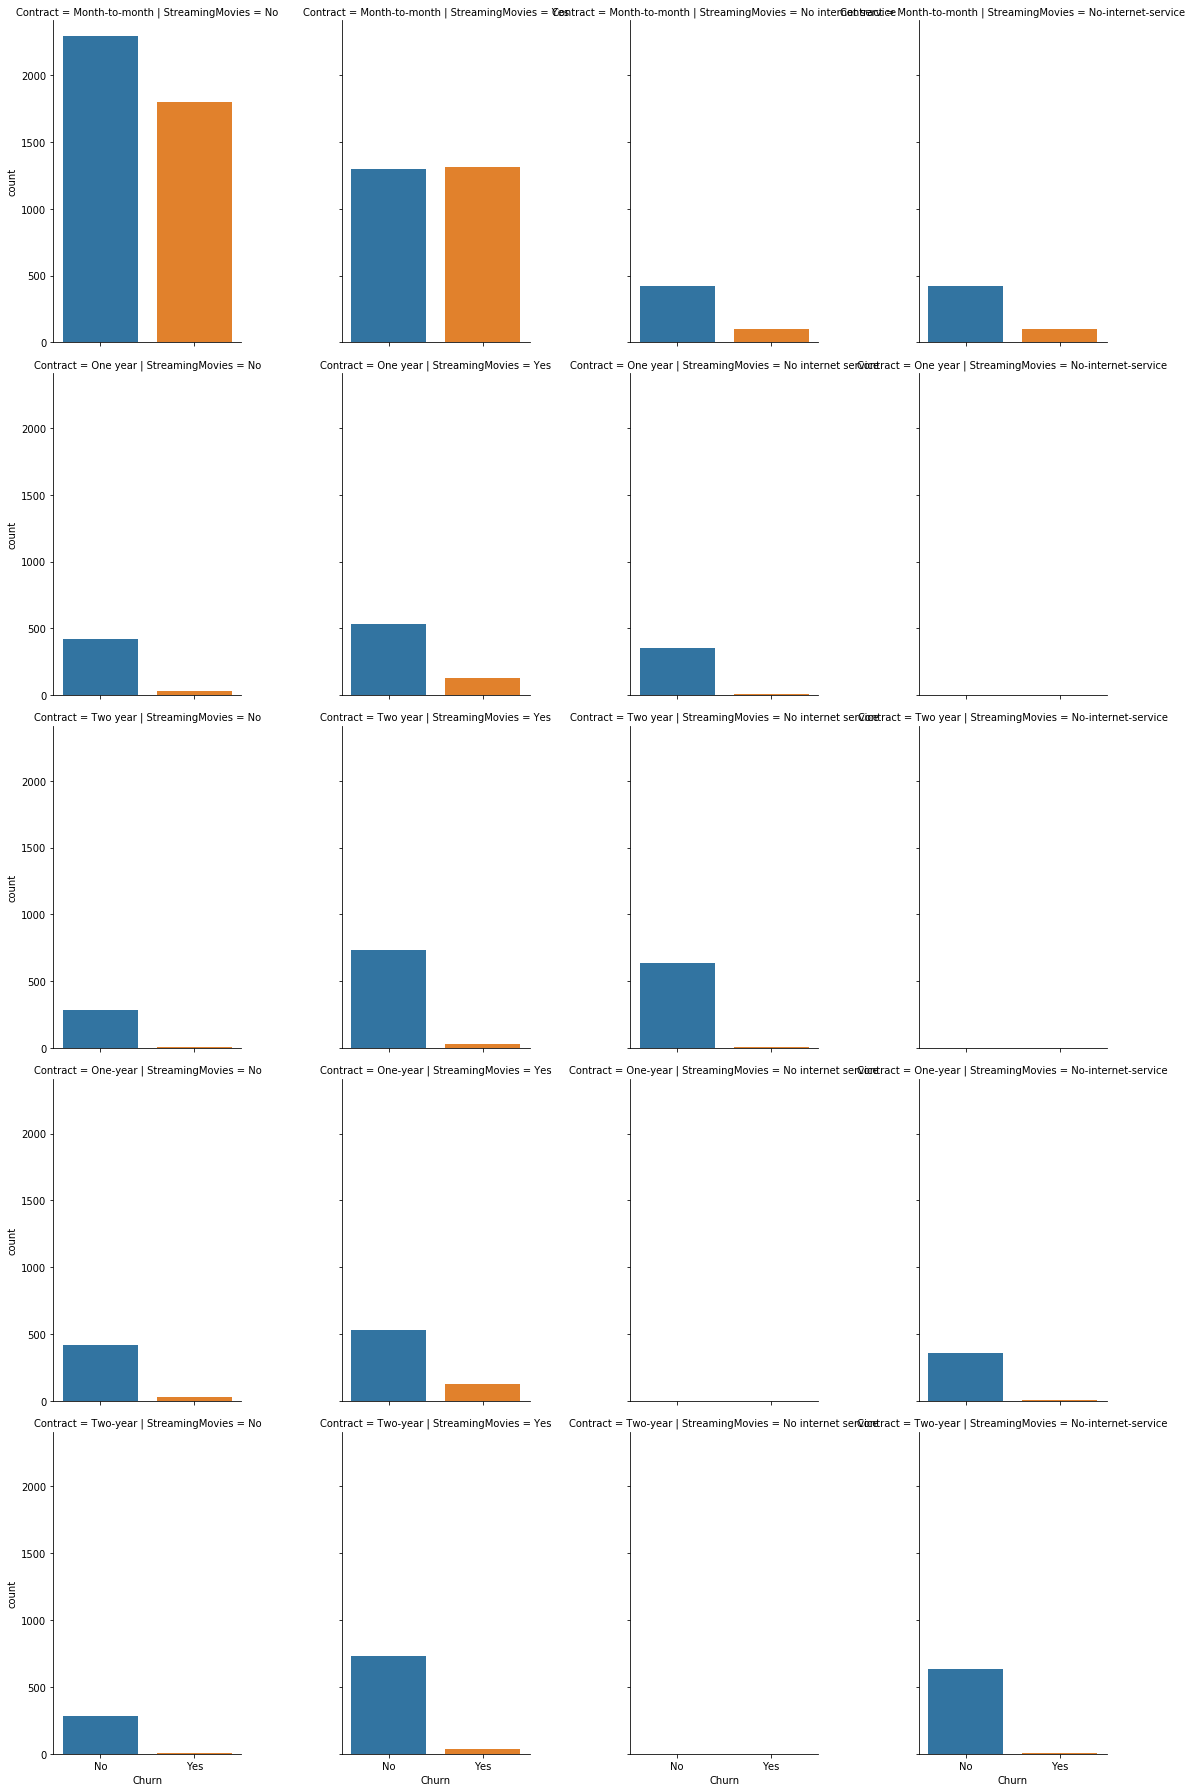

In [40]:
''' === Find/Examine Churned customer  based on different services =====  '''
# customer who Churn by Contract','InternetService'
#df.groupby(['Contract','InternetService'])['Churn'].value_counts()

import seaborn as sns
lists = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies',]

for x in  lists:
    g = sns.catplot('Churn', col=x, row ='Contract', data=df, kind='count', aspect=0.8, hue_order=['g', 'b']) # bar plot

#### Finding:
From the above plots, the large of no. of customer churn belong to customer who had month-to-month contract. Especially, those customer who had phone service and internet-service(Fiber-optic) of month-to-month contract are most likely to stop using the service. 

This can also be observed from the decison-tree diagram in the above. In addition to these, the cusomer have been shorter period (tenure) in the use of service are also mostly likely to leave from the service.

The reasons can be: 1) Company doesn't take necessary steps before contract end, 2) Customer might get better offer from another company, and 3) Since the majority of leaving customer  are from  'phone service' and 'internet-service(Fiber-optic)', the services in these categories should be checked/revised to make sure they are providing the really  better service than the competitor.